In [187]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

In [113]:

# proteomics data 
proteomics_data_raw = pd.read_csv("../data/proteomics/protein_values.csv")

# getting only the values for the second dataset
proteomics_data_raw = proteomics_data_raw[proteomics_data_raw["Dataset"] == 2]

# cell size data 
cell_size_data_raw = pd.read_csv("../data/proteomics/cell_volumes.csv")
cell_size_data = cell_size_data_raw[["Growth condition" ,"Total cell volume calculated (fl)1"]]

# cell growth data 
cell_growth_data_raw = pd.read_csv("../data/proteomics/growth_conditions.csv")

# molecular weight (g/mmol)
mw = proteomics_data_raw["Molecular weight (Da)"] / 1000

# get additional information stored 
proteomics_data_additional_info = proteomics_data_raw.iloc[:, 0:5]
negative_slice = list(map(lambda x: -1*x,list(range(1,4))))
proteomics_data_additional_info = pd.concat([proteomics_data_additional_info, proteomics_data_raw.iloc[:, negative_slice]], axis=1)

# get main information out of df
start = proteomics_data_raw.columns.get_loc("Glucose")
end = proteomics_data_raw.columns.get_loc("Fructose")
proteomics_data = proteomics_data_raw.iloc[:, start:(end+1)]
error_data = proteomics_data_raw.iloc[:, (start+22):(end+23)]



In [114]:
# replace names in errors and convert to n_molecules/cell
replace_names = dict(zip(error_data.columns, [re.sub(r'.1$', '', i) for i in error_data.columns]))
error_data.rename(columns=replace_names, inplace=True)
error_data = proteomics_data / 100 * error_data
replace_names = dict(zip(error_data.columns, [re.sub(r'$', '_uncertainty', i) for i in error_data.columns]))
error_data.rename(columns=replace_names, inplace=True)

In [115]:
# protein counts to moles
proteomics_data = proteomics_data / 6.022e+23 * 1000
water_content = 0.3
cell_density = 1.105e-12
proteomics_data = proteomics_data / cell_density / water_content


In [124]:
# putting all the necessary data together for later export 
proteomics_data_combined = pd.concat([proteomics_data_raw["Dataset"], proteomics_data_additional_info['Uniprot Accession'],proteomics_data, error_data], axis=1)

# putting proteomics data together with cog for later plotting 
proteomics_data_to_plot = pd.concat([proteomics_data, proteomics_data_raw["Annotated functional COG group (description)"]],axis=1)

# renaming for easier access 
proteomics_data_combined.columns = [re.sub(r'\W+', '', "_".join(i.split()).lower()) for i in proteomics_data_combined.columns]
proteomics_data.columns = [re.sub(r'\W+', '', "_".join(i.split()).lower()) for i in proteomics_data.columns]

In [126]:
# cell growth data names to the same convention as the headers on the rest of the data as well as only from the common strain
cell_growth_data = cell_growth_data_raw[cell_growth_data_raw["Strain"] == "BW25113"]

new_rows = [re.sub(r'\W+', '', "_".join(i.split()).lower()).replace("glucose3", "glucose") for i in cell_growth_data["Growth condition"]]
cell_growth_data["Growth condition"] = new_rows

In [127]:
# getting all data necessary for future work into one place
data = cell_size_data['Total cell volume calculated (fl)1'] * water_content * cell_density * 1e12
names = cell_size_data['Growth condition']

# pd.concat([names, data], axis=1)


In [128]:
proteomics_data.columns

Index(['glucose', 'lb', 'glycerol__aa', 'acetate', 'fumarate', 'glucosamine',
       'glycerol', 'pyruvate', 'chemostat_µ05', 'chemostat_µ035',
       'chemostat_µ020', 'chemostat_µ012', 'stationary_phase_1_day',
       'stationary_phase_3_days', 'osmoticstress_glucose', '42c_glucose',
       'ph6_glucose', 'xylose', 'mannose', 'galactose', 'succinate',
       'fructose'],
      dtype='object')

In [129]:
proteomics_data_combined.to_csv("../data/proteomics/proteomics_ecoli_combined.csv")

In [130]:
# data handling for plotting the protein content vs growth rate by category and total
proteomics_sums = proteomics_data.sum(axis=0).to_frame()
proteomics_sums_by_cog = pd.concat([proteomics_data, proteomics_data_raw["Annotated functional COG group (description)"]])


cell_growth_data = cell_growth_data[["Growth condition", "Growth rate (h-1)"]]
proteomics_vs_growth = proteomics_sums.join(cell_growth_data.set_index("Growth condition"))
proteomics_vs_growth.columns = ["protein_sum","growth_rate"]


In [177]:
# aggregate sum of protein mass per cog
proteomics_data_to_plot_aggregated = proteomics_data_to_plot.groupby(["Annotated functional COG group (description)"]).sum()

# sum of all protein mass per sample in percent
cog_in_percent = proteomics_data_to_plot_aggregated.div(proteomics_data_to_plot.sum()) * 100


amino_vs_growth = cog_in_percent.loc["Amino acid transport and metabolism"].to_frame().join(cell_growth_data.set_index("Growth condition"))
energy_vs_growth = cog_in_percent.loc["Energy production and conversion"].to_frame().join(cell_growth_data.set_index("Growth condition"))
translation_vs_growth = cog_in_percent.loc["Translation, ribosomal structure and biogenesis"].to_frame().join(cell_growth_data.set_index("Growth condition"))

amino_vs_growth.iloc[:, 0]

glucose                    11.084655
lb                          3.684457
glycerol__aa                7.009731
acetate                     9.148124
fumarate                    9.562495
glucosamine                 9.455624
glycerol                   10.067435
pyruvate                   10.088407
chemostat_µ05               9.804906
chemostat_µ035              9.357707
chemostat_µ020              9.222156
chemostat_µ012              8.825251
stationary_phase_1_day      6.976767
stationary_phase_3_days     7.168505
osmoticstress_glucose       9.823933
42c_glucose                 9.811511
ph6_glucose                10.111753
xylose                      9.679740
mannose                     9.973027
galactose                   9.363749
succinate                   9.899735
fructose                   10.342456
Name: Amino acid transport and metabolism, dtype: float64

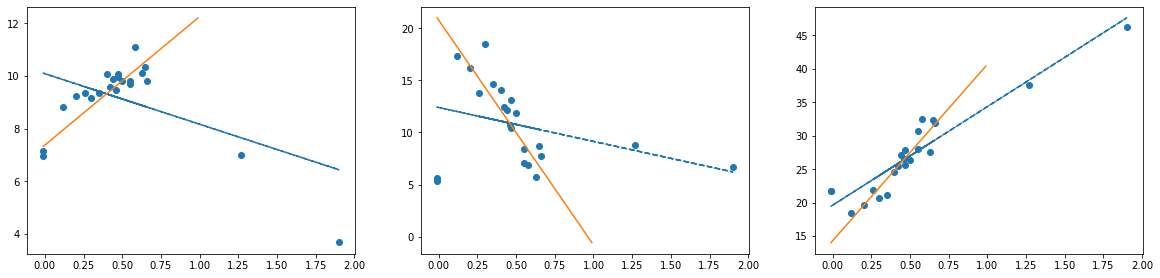

In [196]:
# three paper subplots recreated 
plots = [amino_vs_growth, energy_vs_growth, translation_vs_growth]

# fitting robust linear models to the calculated percentages
# dotted line standard linear model, non-dotted ransac linear model
fig = plt.figure(figsize=[20,10])
for i in range(0, 3):
    ax = fig.add_subplot(2, 3, i+1)
    x = amino_vs_growth["Growth rate (h-1)"]
    y = plots[i].iloc[:, 0]
    ax.scatter(x, y)


    coef = np.polyfit(x,plots[i].iloc[:, 0],1)
    poly1d_fn = np.poly1d(coef) 
    ax.plot(x,poly1d_fn(x), '--')

    ransac = linear_model.RANSACRegressor()
    ransac.fit(x.to_numpy().reshape(-1, 1), y)
    line_X = np.arange(x.min(), x.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    ax.plot(line_X, line_y_ransac)


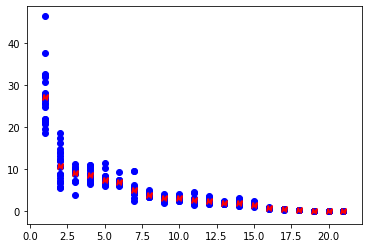

In [253]:
cog_in_percent_with_means = cog_in_percent
cog_in_percent_with_means["means"] = cog_in_percent.mean(axis=1)
cog_in_percent_with_means = cog_in_percent_with_means.sort_values(by=['means'], ascending=False)
means = cog_in_percent_with_means["means"]
#cog_in_percent_sorted = cog_in_percent_with_means.drop(["means"])


# readying for plotting
x = list(range(1, cog_in_percent_with_means.shape[0]+1))
y = [tuple(cog_in_percent_with_means.loc[i]) for i in cog_in_percent_with_means.index]
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye, color="blue")
plt.scatter(x, means, marker="$M$", color="red")
